# MPRA regression with K-fold cross validation

### Environment 
The next chunk contains the commands necessary to install the environment required to run this jupyter notebook
Skip this chunk if the installation was previously done

### Library imports


In [1]:
import os 
import getopt
import sys

import numpy as np
import h5py
import pickle
import random
import copy
import pandas as pd
import math 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer, Lambda, concatenate, Bidirectional, Dense, Dropout, Flatten, Conv1D,BatchNormalization,  MaxPooling1D, Bidirectional, GRU, TimeDistributed
from tensorflow.keras.layers import Normalization
from tensorflow.keras.initializers import Constant
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt


2023-11-08 17:40:37.401891: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 17:40:37.433664: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 17:40:37.433704: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 17:40:37.433726: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 17:40:37.440014: I tensorflow/core/platform/cpu_feature_g

Using TensorFlow backend


### Input ingestion

Here we define the methods to read and ingest data and we initialize the random seed.

Since we are processing the entire sequence the vocabulary is comprised of upper case nucleotides


In [2]:
np.random.seed(1337) # for reproducibility

# Lower case vocabulary
vocab = ["A", "G", "C", "T"]

# These are the defaults of the data reader method 
# (each column in the ingested csv must be initialized with the right data type, otherwise the data ingestion fails )
indices = tf.range(len(vocab), dtype = tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab,indices)
table = tf.lookup.StaticVocabularyTable(table_init, 1)
defs = [0.] * 1 + [tf.constant([], dtype = "string")]

# Nadav dataset

def data_reader(file, batch_size=100, n_parse_threads=4):
    """Method for reading the data in an optimized way, can be used inside model.fit()
    
    Args:
        file (_type_): path to csv file
        batch_size (int, optional): _description_. Defaults to 100.
        n_parse_threads (int, optional): _description_. Defaults to 4.

    Returns:
        dataset.batch: batch dataset object 
    """
    dataset = tf.data.TextLineDataset(file).skip(1)
    dataset=dataset.map(preprocess, num_parallel_calls = n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

def preprocess(record):
    """Preprocessing method of a dataset object, one-hot-encodes the data

    Args:
        record (_type_): _description_

    Returns:
        X (2D np.array): one-hot-encoded input sequence
        Y (1D np.array): MPRA measurements

    """
    fields = tf.io.decode_csv(record, record_defaults=defs)
    chars = tf.strings.bytes_split(fields[1])
    chars_indeces = table.lookup(chars)
    X = tf.one_hot(chars_indeces, depth = len(vocab))
    Y = fields[0]
    return X,Y

2023-11-08 17:40:39.342309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1291 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6


### k-fold cross validation split
Here we take the initial csv file and we split it in 3 partitions k times

It is possible to randomize the sequences and augment, since the masking of the model motifs was a better choice
for understanding the background this strategy is here commented out and not used


In [3]:
# CROSS VALIDATION (10 fold)
import pandas as pd
from sklearn.model_selection import train_test_split, KFold

# Split the data in three partitions
whole_data = pd.read_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3.csv")

kf = KFold(n_splits = 10, shuffle = True, random_state = 2008)

o=1
# For each fold we split again to get the third partition
for i in kf.split(whole_data):
    # Get train/test split and upper case all nucleotides
    train = whole_data.iloc[i[0]]
    train["seq"] = train['seq'].str.upper() 
    
    test =  whole_data.iloc[i[1]]
    test["seq"] = test['seq'].str.upper() 

    train, validation = train_test_split(train, test_size=0.11, random_state=42)
    
    train.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(o)+"_LibA_wide_pivot_state3_train.csv", index=False)
    test.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(o)+"_LibA_wide_pivot_state3_test.csv", index=False)
    validation.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(o)+"_LibA_wide_pivot_state3_validation.csv", index=False)
    o+=1

train

/tmp/ipykernel_1811458/1817506747.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["seq"] = train['seq'].str.upper()
/tmp/ipykernel_1811458/1817506747.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["seq"] = test['seq'].str.upper()


,State_3E,seq
5786,0.053119,AGGACCGGATCAACTGGTGCTGCCGTCACAACGCACTGTGCTTGTT...
5873,-0.077200,AGGACCGGATCAACTGTACAGTTATAAGGTAATCTTGTTCGATAAA...
3331,0.011841,AGGACCGGATCAACTCGACCGGGGTCACCAGGATATTATCAGATGG...
539,-0.103969,AGGACCGGATCAACTAATTGATATTGGCGCGTGTATCCCGAATTTC...
1122,0.036170,AGGACCGGATCAACTACTTGTGTTCAGGCACGATTTCTATCGTCGG...
...,...,...
5792,0.151705,AGGACCGGATCAACTGGTGGTAGCCACCTAGGGATAGCATAGGAGG...
5980,-0.000154,AGGACCGGATCAACTGTCAGAACTGCTTTGCCGACCGCGCTTTCTT...
955,0.039057,AGGACCGGATCAACTACGTAGTGCTTTATACCATCGAACCACTGCG...
8448,0.091301,AGGACCGGATCAACTTTTGTGTAACGCTGTACGGGGCTGGAGATTT...


### Deep Learning model

Here we run the model which is based on this paper : 

https://doi.org/10.1101/2023.03.05.531189

I have added a Normalization layer parametrized with two parameters. 

In [4]:
import matplotlib
df_test_10folds  = pd.DataFrame(columns=['State_3E', "seq", "prediction"])
corr_list = []

# We define a custom normalization layer to then compile on the model
class CustomNormalization(Layer):
    """Custom normalization layer that normalizes the output of the neural network"""
    def __init__(self, **kwargs):
        super(CustomNormalization, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Add trainable variables for mean and standard deviation
        self.mean = self.add_weight("mean", shape=(1,), initializer="zeros", trainable=True)
        self.stddev = self.add_weight("stddev", shape=(1,), initializer="ones", trainable=True)
        super(CustomNormalization, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        # Normalize the inputs using the learned mean and standard deviation
        return (inputs - self.mean) / (self.stddev + 1e-8)

# We define the method to compute the pearson correlation between prediction and ground truth
def pearson_correlation(x, y):
    """Computes Pearson Correlation between x and y
    Args:
        x (np.array): vector of predictions values
        y (np.array): vector of ground truth values

    Returns:
        (float): pearson correlation
    """
    n = len(x)
    
    # Calculate the mean of x and y
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    
    # Calculate the numerator and denominators of the correlation coefficient
    numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
    denominator_x = math.sqrt(sum((xi - mean_x) ** 2 for xi in x))
    denominator_y = math.sqrt(sum((yi - mean_y) ** 2 for yi in y))
    
    # Calculate the correlation coefficient
    correlation = numerator / (denominator_x * denominator_y)
    return correlation

import matplotlib.pyplot as plt
%matplotlib inline
# Define plotting function of loss
def create_plots(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.clf()


#### Model training
Here we iterate through the folds and train the model

In [5]:

i=1
# Define inputs
input_path_train = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_train.csv"
input_path_valid = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_validation.csv"
input_path_test = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_test.csv"

# We load train and valid data as a np array to be able to feed it to the keras tuner
train_data = data_reader(input_path_train,batch_size=100)
y_train = np.empty(shape=[0,1])
X_train = np.empty(shape=[0,262,4])

for batch in train_data:
    y_train =np.append(y_train, batch[1])
    X_train = np.concatenate((X_train, batch[0]), axis=0)

val_data = data_reader(input_path_valid,batch_size=100)
y_val = np.empty(shape=[0,1])
X_val = np.empty(shape=[0,262,4])

for batch in val_data:
    y_val =np.append(y_val, batch[1])
    X_val = np.concatenate((X_val, batch[0]), axis=0)

# Read test data to then predict
df_test = pd.read_csv(input_path_test)

# Get first item of the dataset to get the shape of the input data
for element in data_reader(input_path_train):
    input_shape = element[0].shape

# Define and compile model
def build_model(hp):
    inputs = Input(shape=(input_shape[1], input_shape[2]), name="inputs")
    layer = Conv1D(hp.Int('conv1_units', min_value=100, max_value=300, step=32), kernel_size=hp.Int('conv1_kernel', min_value=3, max_value=10, step=2), activation="relu", name="conv1")(inputs)
    layer = Dropout(hp.Float('conv1_dropout', min_value=0.1, max_value=0.5, step=0.1))(layer)
    layer = BatchNormalization()(layer)
    layer = Conv1D(hp.Int('conv2_units', min_value=100, max_value=300, step=32), hp.Int('conv2_kernel', min_value=3, max_value=10, step=2), activation="softmax", name="conv2")(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
    layer = Dropout(hp.Float('maxpool1_dropout', min_value=0.1, max_value=0.5, step=0.1))(layer)
    layer = Conv1D(hp.Int('conv3_units', min_value=100, max_value=300, step=32), hp.Int('conv3_kernel', min_value=2, max_value=5, step=2), activation="softmax", name="conv3")(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(hp.Float('conv3_dropout', min_value=0.1, max_value=0.5, step=0.1))(layer)
    layer = Conv1D(hp.Int('conv4_units', min_value=50, max_value=250, step=32), hp.Int('conv4_kernel', min_value=1, max_value=3, step=2), activation="softmax", name="conv4")(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
    layer = Dropout(hp.Float('maxpool2_dropout', min_value=0.1, max_value=0.5, step=0.1))(layer)
    layer = Flatten()(layer)
    layer = Dense(hp.Int('dense1_units', min_value=150, max_value=300, step=32), activation="sigmoid")(layer)
    layer = Dropout(hp.Float('dense1_dropout', min_value=0.1, max_value=0.5, step=0.1))(layer)
    layer = Dense(hp.Int('dense2_units', min_value=150, max_value=300, step=32), activation="sigmoid")(layer)
    predictions = Dense(1, activation='linear')(layer)
    norm_predictions = CustomNormalization()(predictions)  # Assuming "predictions" is your existing output
    model = Model(inputs=inputs, outputs=norm_predictions)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mean_squared_error',
        metrics=['mae', "mse"]
    )
    return model

tuner = kt.Hyperband(
		build_model,
		objective="val_mse",
		max_epochs=20,
		factor=3,
		seed=42)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Search for the best hyperparameters
tuner.search(x=X_train,
             y=y_train,
             validation_data=(X_val,y_val),
             epochs=20,
             callbacks=[stop_early]
             )  # You can adjust the number of epochs



best_hps = tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete thse are the best hps \n:
{best_hps.values}""")

final_model = tuner.hypermodel.build(best_hps)

# Run model
history=final_model.fit(data_reader(input_path_train, batch_size=200),
                        epochs=20,
                        validation_data=data_reader(input_path_valid,batch_size=100),
                        callbacks=None,
                        verbose=1)



Trial 29 Complete [00h 01m 17s]
val_mse: 0.013419228605926037

Best val_mse So Far: 0.011838812381029129
Total elapsed time: 00h 24m 48s

The hyperparameter search is complete thse are the best hps 
:
{'conv1_units': 196, 'conv1_kernel': 5, 'conv1_dropout': 0.5, 'conv2_units': 164, 'conv2_kernel': 9, 'maxpool1_dropout': 0.5, 'conv3_units': 292, 'conv3_kernel': 2, 'conv3_dropout': 0.2, 'conv4_units': 82, 'conv4_kernel': 3, 'maxpool2_dropout': 0.1, 'dense1_units': 310, 'dense1_dropout': 0.1, 'dense2_units': 342, 'learning_rate': 0.0001, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Epoch 1/20


2023-11-08 17:50:12.990743: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 189.36MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


     31/Unknown - 4s 25ms/step - loss: 0.1365 - mae: 0.2757 - mse: 0.1365

2023-11-08 17:50:14.662391: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 182.27MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


34/34 [==============================] - 5s 60ms/step - loss: 0.1271 - mae: 0.2636 - mse: 0.1271 - val_loss: 0.0303 - val_mae: 0.1452 - val_mse: 0.0303
Epoch 2/20
 4/34 [==>...........................] - ETA: 0s - loss: 0.0317 - mae: 0.1471 - mse: 0.0317

2023-11-08 17:50:15.431879: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3411780013948306515
2023-11-08 17:50:15.431947: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6093231065930492830


34/34 [==============================] - 1s 30ms/step - loss: 0.0254 - mae: 0.1186 - mse: 0.0254 - val_loss: 0.0209 - val_mae: 0.1032 - val_mse: 0.0209
Epoch 3/20
34/34 [==============================] - 1s 31ms/step - loss: 0.0230 - mae: 0.1108 - mse: 0.0230 - val_loss: 0.0208 - val_mae: 0.0994 - val_mse: 0.0208
Epoch 4/20
34/34 [==============================] - 1s 31ms/step - loss: 0.0226 - mae: 0.1098 - mse: 0.0226 - val_loss: 0.0209 - val_mae: 0.0988 - val_mse: 0.0209
Epoch 5/20
34/34 [==============================] - 1s 31ms/step - loss: 0.0221 - mae: 0.1087 - mse: 0.0221 - val_loss: 0.0209 - val_mae: 0.0987 - val_mse: 0.0209
Epoch 6/20
34/34 [==============================] - 1s 30ms/step - loss: 0.0202 - mae: 0.1063 - mse: 0.0202 - val_loss: 0.0211 - val_mae: 0.0981 - val_mse: 0.0211
Epoch 7/20
34/34 [==============================] - 1s 29ms/step - loss: 0.0194 - mae: 0.1054 - mse: 0.0194 - val_loss: 0.0209 - val_mae: 0.0988 - val_mse: 0.0209
Epoch 8/20
34/34 [===============

In [9]:

#After training we save the model weights to then run the contribution scores
model_path = '/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/Model_CV'+str(i)+"_LibA_wide_pivot_state3_hyperparam_tunning.h5"
final_model.save_weights(model_path, save_format='h5')

# We predict the test data
predicted = final_model.predict(data_reader(input_path_test,
                                            batch_size=100))

# We fill the dataframe with predictions and fold annotation
test_data = data_reader(input_path_test,batch_size=100)
test_tensor = np.empty(shape=[0,1])
for batch in test_data:
    test_tensor = np.append(test_tensor, batch[1])

# Append fold to previous folds
df_test["prediction"] = predicted
df_test["fold"] = str(i)
df_test_10folds = pd.concat([df_test_10folds, df_test], ignore_index=True)    

# Append correlation coefficient and append to previous        
corr_coefficient = pearson_correlation(predicted.flatten(), test_tensor)
corr_list.append(corr_coefficient)

df_test_10folds.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/LibA_wide_pivot_state3_test_predicted_hyperparam_tunning.csv", index=False)
print(corr_list)
df_test_10folds

9/9 [==============================] - 0s 10ms/step
[0.6250821511914249, 0.6250821511914249]


,State_3E,seq,prediction,fold
0,-0.007714,AGGACCGGATCAACTAAACAACTCAAACAAGGGCTAATATAACCCA...,0.018103,1
1,0.137953,AGGACCGGATCAACTAAACACTAGTCATACTTAAAAATTGCAAGGA...,0.029765,1
2,-0.048706,AGGACCGGATCAACTAAACAGGTTCTGACGTATGCTCCTCTATGGA...,0.031707,1
3,-0.052804,AGGACCGGATCAACTAAACCCGAGCCTGCCTAGCCCTAGCTTCTCT...,0.030516,1
4,0.213652,AGGACCGGATCAACTAAACGGAGCAGAGTTAGTGTCAGGTCAAAAA...,0.018286,1
...,...,...,...,...
1691,0.080956,AGGACCGGATCAACTTTTGTATTGCGTGGGCAGCCGTGGTGGACTC...,0.035952,1
1692,-0.048439,AGGACCGGATCAACTTTTTATTGGACTCAATTGAAGGTCGTGGCGT...,0.043022,1
1693,0.063280,AGGACCGGATCAACTTTTTCATCACATGCGGGCGAATAGGACTATA...,0.064511,1
1694,0.232320,AGGACCGGATCAACTTTTTTCTCCTCCGATACTGTACGTTACTCTT...,0.047724,1


In [10]:
final_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 258, 196)          4116      
                                                                 
 dropout_5 (Dropout)         (None, 258, 196)          0         
                                                                 
 batch_normalization_4 (Bat  (None, 258, 196)          784       
 chNormalization)                                                
                                                                 
 conv2 (Conv1D)              (None, 250, 164)          289460    
                                                                 
 batch_normalization_5 (Bat  (None, 250, 164)          656       
 chNormalization)                                          

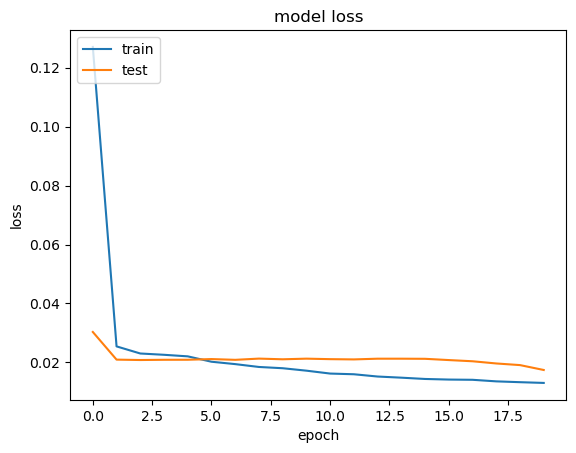

<Figure size 640x480 with 0 Axes>

In [11]:
create_plots(history)